## Faster R-CNN

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

In [ ]:
import torch
import math
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import torchvision
if not torch.cuda.is_available():
    raise RuntimeError("You should enable GPU runtime.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]


In [ ]:
def show_image(pil_im):
    plt.imshow(np.asarray(pil_im))

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign

class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None, num_classes=91):
        super().__init__()
        # First, set the backbone that we will use to extract the feature maps
        self.backbone = backbone

        out_channels = backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

        # Declare the anchor generator of the Region Proposal Network (RPN)
        rpn_anchor_generator = AnchorGenerator(
            anchor_sizes, aspect_ratios
        )

        # Declare the Head of the RPN that will classify the proposals
        rpn_head = RPNHead(
            out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
        )
        rpn_pre_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}
        rpn_post_nms_top_n = {"training": rpn_post_nms_top_n_train, "testing": rpn_post_nms_top_n_test}

        # Create the RPN combining the anchor generator and the head
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)
        
        # ROI Align
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)

        resolution = box_roi_pool.output_size[0]
        representation_size = 1024

        # Simple Head made of 2 Fully Connected layers
        box_head = None

        representation_size = 1024

        # Predictor with 2 outputs (scores and Bounding Boxes deltas)
        box_predictor = None

        # Module that combines the last modules to compute the prediction of every box and match 
        # targets and proposalt in training 
        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)
        min_size=800
        max_size=1333
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]

        # Module that does the correct data augmentation
        self.transform = GeneralizedRCNNTransform(min_size, max_size, self.image_mean, self.image_std)

    def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]])
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        original_image_sizes = []
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        return detections, losses


In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone("resnet50", pretrained=True)
backbone

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1,

In [ ]:
model = FasterRCNN(backbone)

## Exercise 1:
Complete the code for `TwoMLPHead`. This module goes on top of the Region Proposal Network. It should have two Linear layers with intermidiate size of `representation_size` and output size of also `representation_size`. The input `x` for it will be of size `[batch, 256, 7, 7]`, you will have to flatten it. (`in_size=256*7*7`). Use `F.relu` after each linear layer.

In [ ]:
class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_size (int): number of inputs
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_size, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_size, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)


    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x
        

## Exercise 2
Now, complete the code for the predictor. Note that this predictor has 2 outputs, the predicted class (of size `num_classes`) and the bounding box deltas (of size `4*num_classes`). The 4 comes from the 4 bounding box sides. The input now will be of size `[batch, in_size]`. Don't add any activations.

In [ ]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_size (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_size, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_size, num_classes)
        self.bbox_pred = nn.Linear(in_size, 4*num_classes)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
in_size = 256*7*7
representation_size = 1024
num_classes = 91

In [ ]:
model.roi_heads.box_head = TwoMLPHead(in_size, representation_size)
model.roi_heads.box_predictor = FastRCNNPredictor(representation_size, num_classes)


In [ ]:
url = "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
state_dict =  torch.hub.load_state_dict_from_url(url)
model.load_state_dict(state_dict)
model.to(device).eval();

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


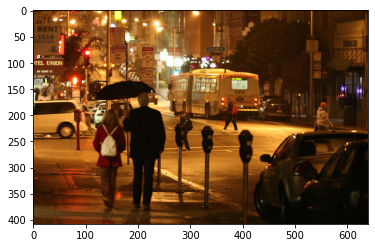

In [ ]:
from urllib.request import urlretrieve
urlretrieve("https://farm1.staticflickr.com/76/152982198_da205ee3dc_z.jpg", "image.jpg")
im = Image.open("image.jpg")
show_image(im)

In [ ]:
a = urlretrieve("https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-2014_2017.txt", "labels.txt")
coco_labels = ["background"]
with open("labels.txt", "r") as f:
    for line in f.readlines():
        coco_labels.append(line.replace("\n", ""))
print(coco_labels)

['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
from torchvision.transforms.functional import to_tensor
x = to_tensor(im).to(device)
targets = None


In [ ]:
transformed, _ = model.transform([x], targets)


The first part of the network is a backbone for feature extraction. To do it, we will use a Feature Pyramidal Network with a ResNet50. The idea of these feature extraction network is to have semantically strong features of different scale.

![FPN1](https://cdn-images-1.medium.com/freeze/max/1000/1*7KbOAExR3E05ZDv0CwXWjg.png?q=20)

Here, the scale of the features are represented with the size, and the semantical meaning of the features is represented with the thickness of the blue outline. Feature Pyramid Networks achieve semantically storng features at different object scales (whch will help to detect small and big objects).


The architecture of these feature extractor is the following one (1x1 and 3x3 represent convolutions):

<img src="https://miro.medium.com/max/968/1*edviRcl3vwlyx9TS_gRbmg.png" alt="Kitten"
	title="arch" width="600"/>

In [ ]:
feature_maps = model.backbone(transformed.tensors)

In [ ]:
print({k: v.shape for k, v in feature_maps.items()})

{'0': torch.Size([1, 256, 200, 320]), '1': torch.Size([1, 256, 100, 160]), '2': torch.Size([1, 256, 50, 80]), '3': torch.Size([1, 256, 25, 40]), 'pool': torch.Size([1, 256, 13, 20])}


In [ ]:
proposals, proposal_losses = model.rpn(transformed, feature_maps, targets)

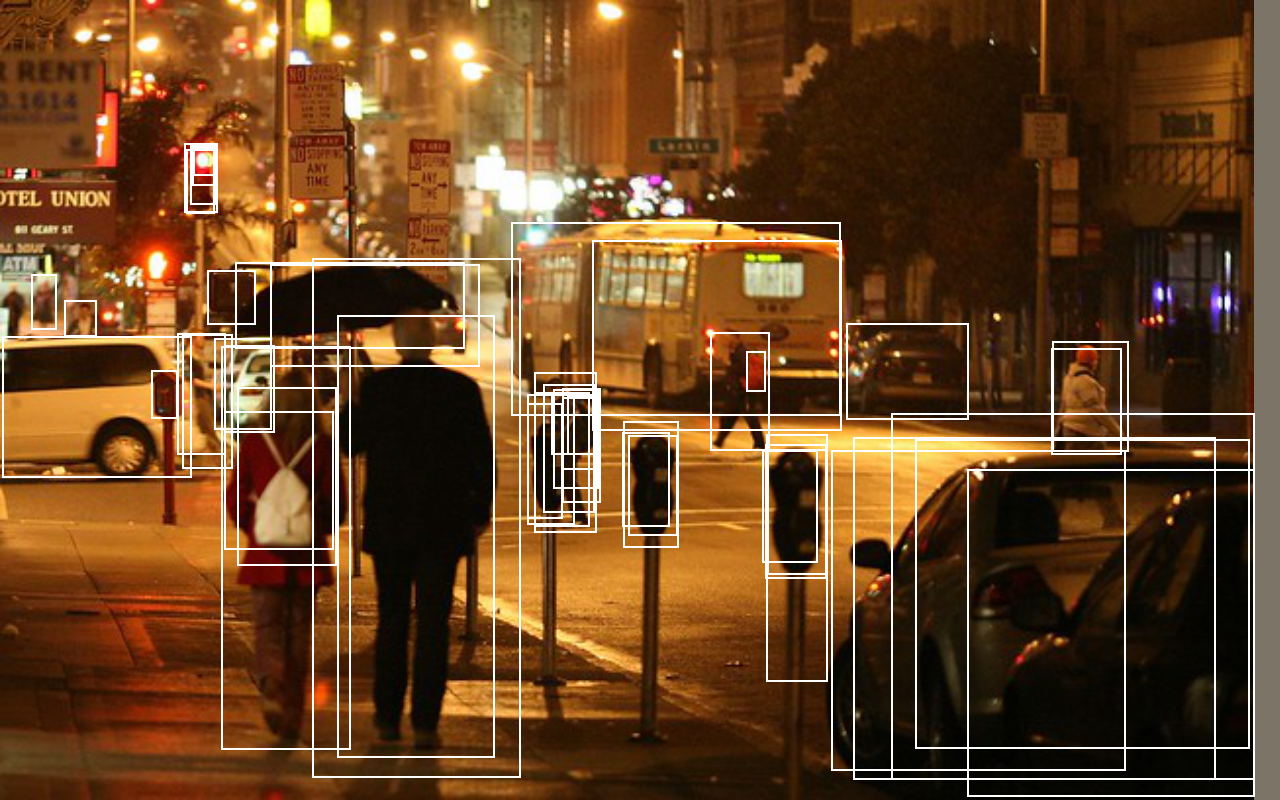

In [ ]:
from torchvision.transforms.functional import to_pil_image

aux = transformed.tensors[0].cpu()
aux = aux*torch.tensor(model.image_std).reshape(3,1,1)+torch.tensor(model.image_mean).reshape(3,1,1)
trnasformed_im = to_pil_image(aux)
draw = ImageDraw.Draw(trnasformed_im)
for p in proposals[0][:50]:
    coords = p.cpu().detach().tolist()
    draw.rectangle(coords, width=2)
trnasformed_im

In [ ]:
detections, detector_losses = model.roi_heads(feature_maps, proposals, transformed.image_sizes, targets)


In [ ]:
detections = model.transform.postprocess(detections, transformed.image_sizes, [[im.height, im.width]])


In [ ]:
detections = detections[0]

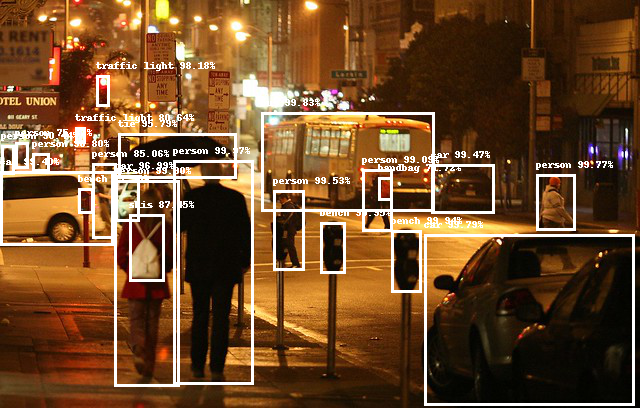

In [ ]:
iou_threshold = 0.2
scores_threshold = 0.6

keep_idx = torchvision.ops.nms(detections["boxes"], detections["scores"], iou_threshold)
boxes = [b for i, b in enumerate(detections["boxes"]) if i in keep_idx]
scores = [s for i, s in enumerate(detections["scores"]) if i in keep_idx]
labels = [l for i, l in enumerate(detections["labels"]) if i in keep_idx]
draw = ImageDraw.Draw(im)
for box, score, label in zip(boxes, scores, labels):
    if score > scores_threshold:
        coords = box.cpu().tolist()
        draw.rectangle(coords, width=3)
        text = f"{coco_labels[label.item()]} {score*100:.2f}%"
        draw.text([coords[0], coords[1]-15], text)
im

## Transfer learning

In [ ]:

class ShapesDataset:
    label2idx = {"circle": 1, "square": 2, "triangle": 3}

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = [random.randint(0, 255) for _ in range(3)]
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        labels = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            labels.append(self.label2idx[shape])
            x, y, s = dims
            boxes.append([x-s, y-s, x+s, y+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = self.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        labels = [l for i, l in enumerate(labels) if i in keep_ixs]
        boxes = [b for i, b in enumerate(boxes) if i in keep_ixs]

        im = Image.new('RGB', (height, width), tuple(bg_color))
        draw = ImageDraw.Draw(im)
        for shape, color, (x, y, s) in shapes:
            if shape == "circle":
                draw.ellipse((x-s, y-s, x+s, y+s), fill=color)
            elif shape == "triangle":
                points = [(x, y-s), (x-s/math.sin(math.radians(60)), y+s), (x+s/math.sin(math.radians(60)), y+s)]
                draw.polygon(points, fill=color)
            elif shape == "square":
                draw.rectangle((x-s, y-s, x+s, y+s), fill=color)
        del draw

        return im, boxes, labels
    
    def non_max_suppression(self, boxes, scores, threshold):
        """Performs non-maximum suppression and returns indices of kept boxes.
        boxes: [N, (x1, y1, x2, y2)]. Notice that (x2, y2) lays outside the box.
        scores: 1-D array of box scores.
        threshold: Float. IoU threshold to use for filtering.
        """
        assert boxes.shape[0] > 0
        if boxes.dtype.kind != "f":
            boxes = boxes.astype(np.float32)

        # Compute box areas
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        area = (y2 - y1) * (x2 - x1)

        # Get indicies of boxes sorted by scores (highest first)
        ixs = scores.argsort()[::-1]

        pick = []
        while len(ixs) > 0:
            # Pick top box and add its index to the list
            i = ixs[0]
            pick.append(i)
            # Compute IoU of the picked box with the rest
            iou = self.compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
            # Identify boxes with IoU over the threshold. This
            # returns indices into ixs[1:], so add 1 to get
            # indices into ixs.
            remove_ixs = np.where(iou > threshold)[0] + 1
            # Remove indices of the picked and overlapped boxes.
            ixs = np.delete(ixs, remove_ixs)
            ixs = np.delete(ixs, 0)
        return np.array(pick, dtype=np.int32)

    def compute_iou(self, box, boxes, box_area, boxes_area):
        """Calculates IoU of the given box with the array of the given boxes.
        box: 1D vector [x1, y1, x2, y2]
        boxes: [boxes_count, (x1, y1, x2, y2)]
        box_area: float. the area of 'box'
        boxes_area: array of length boxes_count.
        Note: the areas are passed in rather than calculated here for
        efficiency. Calculate once in the caller to avoid duplicate work.
        """
        # Calculate intersection areas
        x1 = np.maximum(box[0], boxes[:, 0])
        x2 = np.minimum(box[2], boxes[:, 2])
        y1 = np.maximum(box[1], boxes[:, 1])
        y2 = np.minimum(box[3], boxes[:, 3])
        intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
        union = box_area + boxes_area[:] - intersection[:]
        iou = intersection / union
        return iou

In [ ]:
shapes_dataset = ShapesDataset()


([[93, 132, 147, 186], [58, 47, 124, 113], [54, 126, 122, 194]], [1, 3, 2])

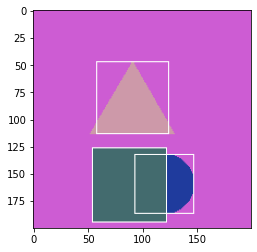

In [ ]:
im, boxes, labels = shapes_dataset.random_image(200, 200)
draw = ImageDraw.Draw(im)
for b in boxes:
    draw.rectangle(b)
del draw
show_image(im)
boxes, labels

In [ ]:
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.utils.data import Dataset

class PytorchDaset(Dataset):
    def __init__(self, shapes_dataset, iterations=2000, device="cpu"):
        super().__init__()
        self.shapes_dataset = shapes_dataset
        self.iterations = iterations
    
    def __getitem__(self, idx):
        im, boxes, labels = shapes_dataset.random_image(100, 100)
        targets = {"boxes": torch.tensor(boxes, dtype=torch.float32, device=device), 
                   "labels": torch.tensor(labels, dtype=torch.int64, device=device)}
        return to_tensor(im).to(device), targets
    
    def __len__(self):
        return self.iterations

In [ ]:
dataset = PytorchDaset(shapes_dataset)
def collate_fn(batch):
    images = []
    targets = []
    for i, t in batch:
        images.append(i)
        targets.append(t)
    return images, targets

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, num_workers=0,
    collate_fn=collate_fn)

## Exercise 3
Replace the `model.roi_heads.box_predictor` by a new untrained `FastRCNNPredictor`, and use an ADAM optimizer to train only this new module. Add a weight decay of 0.0001.

In [ ]:
num_classes = 4

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.train().to(device)
optimizer = optim.Adam(model.roi_heads.box_predictor.parameters(), weight_decay=0.0001)  

### Exercise 4

Complete the training loop.

In [ ]:
model.train()
for i, (images, targets) in enumerate(data_loader):
    optimizer.zero_grad()
    predictions, loss_dict = model(images, targets)
    loss = sum(loss for loss in loss_dict.values())
    loss.backward()
    optimizer.step()

    if i%2 == 0:
        loss_dict_printable = {k: f"{v.item():.2f}" for k, v in loss_dict.items()}
        print(f"[{i}/{len(data_loader)}] loss: {loss_dict_printable}")

[0/500] loss: {'loss_classifier': '1.44', 'loss_box_reg': '0.27', 'loss_objectness': '0.12', 'loss_rpn_box_reg': '0.01'}
[2/500] loss: {'loss_classifier': '0.61', 'loss_box_reg': '0.42', 'loss_objectness': '0.09', 'loss_rpn_box_reg': '0.01'}
[4/500] loss: {'loss_classifier': '0.34', 'loss_box_reg': '0.30', 'loss_objectness': '0.06', 'loss_rpn_box_reg': '0.01'}
[6/500] loss: {'loss_classifier': '0.43', 'loss_box_reg': '0.36', 'loss_objectness': '0.09', 'loss_rpn_box_reg': '0.01'}
[8/500] loss: {'loss_classifier': '0.59', 'loss_box_reg': '0.46', 'loss_objectness': '0.31', 'loss_rpn_box_reg': '0.03'}
[10/500] loss: {'loss_classifier': '0.23', 'loss_box_reg': '0.17', 'loss_objectness': '0.06', 'loss_rpn_box_reg': '0.00'}
[12/500] loss: {'loss_classifier': '0.37', 'loss_box_reg': '0.23', 'loss_objectness': '0.06', 'loss_rpn_box_reg': '0.01'}
[14/500] loss: {'loss_classifier': '0.30', 'loss_box_reg': '0.20', 'loss_objectness': '0.11', 'loss_rpn_box_reg': '0.02'}
[16/500] loss: {'loss_classif

KeyboardInterrupt: ignored

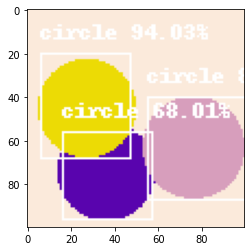

In [ ]:
model = model.eval()
image, target = dataset[0] # Random image
with torch.no_grad():
    detections, loss_dict = model([image], targets=None)
detections = detections[0]
iou_threshold = 0.2
score_threshold = 0.4
keep_idx = torchvision.ops.nms(detections["boxes"], detections["scores"], iou_threshold)
boxes = [b for i, b in enumerate(detections["boxes"]) if i in keep_idx]
scores = [s for i, s in enumerate(detections["scores"]) if i in keep_idx]
labels = [l for i, l in enumerate(detections["labels"]) if i in keep_idx]
im = to_pil_image(image.cpu())
draw = ImageDraw.Draw(im)
idx2label = {v: k for k, v in shapes_dataset.label2idx.items()}
for box, score, label in zip(boxes, scores, labels):
    if score > score_threshold:
        coords = box.cpu().tolist()
        draw.rectangle(coords)
        text = f"{idx2label[label.item()]} {score*100:.2f}%"
        draw.text([coords[0], coords[1]-15], text)

show_image(im)